# Data Gathering and Selection

The first step in any project is making sure we have the right data. For this use case and example, we're going to be leveraging some public data from Cook County, Illinois, USA. In an open data initiative, the county has made public the awarded contracts with various parties. For additional details on the data source, please see the link below:

https://datacatalog.cookcountyil.gov/Administration-Operations/Procurement-Awarded-Contracts-Amendments/qh8j-6k63/about_data

From the Cook County webpage, we have a CSV file provided by Cook County that lists out the various contracts that have been awarded by their procurement team.

Our steps will be to:
- Load and examine the CSV provided by Cook County
- Identify a subset that we will download and use for this use case
    - Primarily we will download the Master Service Agreements (MSAs), as these will have the most content and contract terms and conditions
    - We will also download a sample of request for proposals (RFPs), request for quotes (RFQs), and Bids
    - For the purposes of demonstration to make this scenario realistic, we need to have a variety of document types, since we rarely get a nice clean sample of only one document type
- Write code to pull URL location of the documents from the CSV and automatically download the PDF files to a single folder
- Data confirmation step -- compare to metadata to confirm all documents we expect to see are present

<br/>

**Please note** that the automatic download of data in this notebook is set up to run on Chrome on Mac. Adjustments may be necessary for other systems and will be necessary for other browsers.

<br/>
<br/>

## Dependencies & Configuations

First, let's load in the various required packages that we will need

In [2]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import os
import time
from time import sleep
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv

<br/>

Set home directory - we suggest making this the data folder in the repo and saving your data here:

In [3]:
load_dotenv()
HOME_DIRECTORY = os.getenv("HOME_DIRECTORY")

<br/>
<br/>

## Reference Data Load

<br/>

Now, let's load in the contract metadata from Cook County to inspect the data. 

After a first look, we're going to need to subset the dataset and look just at rows where a PDF is going to be available. We also can create our own ID number from the filename to do some checks.

In [4]:
contracts = pd.read_csv(os.path.join(HOME_DIRECTORY, 'data', 'Contracts_20231227.csv'))
contracts['URL ID'] = contracts['Contract PDF'].apply(lambda x: x.split('/')[-1].split('=')[-1] if type(x)==str else x)
contracts[pd.isna(contracts['Contract PDF'])==False].head()

/var/folders/v5/zjyjffl52010h549863n0ggm0000gn/T/ipykernel_13119/3393369456.py:1: DtypeWarning: Columns (2,18) have mixed types. Specify dtype option on import or set low_memory=False.
  contracts = pd.read_csv(os.path.join(HOME_DIRECTORY, 'data', 'Contracts_20231227.csv'))


,Purchase Order Description,Purchase Order (Contract) Number,Revision Number,Specification Number,Contract Type,Start Date,End Date,Approval Date,Department,Vendor Name,Vendor ID,Address 1,Address 2,City,State,Zip,Award Amount,Procurement Type,Contract PDF,URL ID
114908,FY '09 HOMELESS SERVICES,18866,0,70443,DELEGATE AGENCY,01/01/2009,12/31/2010,01/23/2009,DEPT OF FAMILY AND SUPPORT SERVICES,SARAH'S CIRCLE,99253746H,4750 N SHERIDAN RD # 220,NaN,CHICAGO,IL,60640,29250.0,RFP,http://ecm.cityofchicago.org/eSMARTContracts/s...,000037ZS
114909,PARTS/SERVICE FOR HEAVY MACHINERY AND EQUIPMENT,T24777,0,B29295042,Term Agreement,09/01/2002,08/31/2005,09/16/2002,DEPT OF FLEET MGMT,MCALLISTER EQUIPMENT CO,31303303L,PO BOX 1237,NaN,BEDFORD PARK,IL,60499-1237,0.0,NaN,http://ecm.cityofchicago.org/eSMARTContracts/s...,000001W1
114910,"CDBG YEAR XXVIII TRAINING, PLACEMENT & RETENTI...",D2952390803,0,NaN,NaN,01/01/2002,12/31/2002,01/16/2002,MAYORS OFFICE OF WORKFORCE DEVELOPMENT,CHICAGO ANTI-HUNGER FEDERATION,6677146M,4345 W DIVISION ST,NaN,CHICAGO,IL,60651,48000.0,NaN,http://ecm.cityofchicago.org/eSMARTContracts/s...,000004P9
114911,CORPORATE - 2009 CRC,19163,0,71108,DELEGATE AGENCY,01/01/2009,12/31/2009,04/06/2009,DEPT OF PLANNING & DEVELOPMENT,LAKESIDE COMMUNITY DE. CORP,58810912M,1652 W WALLEN AVE,NaN,CHICAGO,IL,60626,45000.0,RFP,http://ecm.cityofchicago.org/eSMARTContracts/s...,000039ZT
114912,Mayfair Commons,72263,0,685756,COMPTROLLER-OTHER,09/07/2017,12/31/2042,02/20/2018,DEPT OF PLANNING & DEVELOPMENT,NORTH RIVER COMMISSION 02,93461821H,3403 W LAWRENCE AVENUE EFT,NaN,CHICAGO,IL,60625,3551498.0,NaN,http://ecm.cityofchicago.org/eSMARTContracts/s...,{4C3E6E63-A429-424C-A391-1A49117535CD}


<br/>

Let's do a verification / check - how many have URLs listed?

In [5]:
len(contracts[pd.isna(contracts['Contract PDF'])==False]), len(contracts[pd.isna(contracts['Contract PDF'])==False])/len(contracts)

(53213, 0.31651608067998643)

About 32% - but this will be the sample we're limited to, where the documents will actually be available for download.

<br/><br/>

## Select a Data Sample

Let's explore our data a bit more - with over 53,000 documents that we could plausibly download as part of this effort, we should be strategic about the subset we choose.

First, let's look at the types of contract or document we have for the distribution, where values are present:

In [6]:
contracts[pd.isna(contracts['Contract PDF'])==False]['Procurement Type'].value_counts()

Procurement Type
BID                             15541
RFP                              7963
SOLE SOURCE                      1731
RFQ                              1714
MASTER AGREEMENT                 1473
EMERGENCY                         187
REFERENCE CONTRACT                 92
RFI                                88
JOINT PURCHASE                     84
CM                                 36
CONTRACT ASSIGNMENT/TRANS          36
CONTRACT ASSIGNMENT/TRANSFER        7
TASK ORDER                          3
NON-DPS                             1
INNOVATIVE PROCUREMENT              1
Name: count, dtype: int64

<br/>

Next, let's see what we have - first looking and the type of goods or services provided by Master Agreements, which will be our main target for analysis:

In [7]:
contracts[(pd.isna(contracts['Contract PDF'])==False)&(contracts['Procurement Type']=='MASTER AGREEMENT')]['Contract Type'].value_counts()

Contract Type
PRO SERV CONSULTING $250,000orABOVE    673
ARCH/ENGINEERING                       661
DEMOLITION                             110
CONSTRUCTION SERVICES                    8
ARCH/ENGINEERING-AVIATION                7
ROOFING                                  5
JOC                                      4
PRO SERV CONSULTING UNDER $250,000       4
WORK SERVICES-SMALL ORDERS               1
Name: count, dtype: int64

<br/>

Let's look at the same for RFPs and Bids:

In [8]:
contracts[(pd.isna(contracts['Contract PDF'])==False)&(contracts['Procurement Type']=='RFP')]['Contract Type'].value_counts()

Contract Type
DELEGATE AGENCY                        6497
PRO SERV CONSULTING $250,000orABOVE     519
ARCH/ENGINEERING                        513
PRO SERV-AVIATION                       175
ARCH/ENGINEERING-AVIATION                82
WORK SERVICES / FACILITIES MAINT.        61
PRO SERV CONSULTING UNDER $250,000       35
HARDWARE                                 17
COMMODITIES                              16
COMPTROLLER-OTHER                        11
TELECOMMUNICATIONS                       10
PRO SERV                                  9
SOFTWARE                                  8
VEHICLES/HEAVY EQUIPMENT (CAPITAL)        2
REVENUE                                   2
CONSTRUCTION-GENERAL                      2
PRO SERV-BUSINESS CONSULTING              1
CONSTRUCTION SERVICES                     1
COMMODITIES-SMALL ORDERS                  1
CONSTRUCTION-LARGE $3MILLIONorABOVE       1
Name: count, dtype: int64

In [9]:
contracts[(pd.isna(contracts['Contract PDF'])==False)&(contracts['Procurement Type']=='BID')]['Contract Type'].value_counts()

Contract Type
CONSTRUCTION-LARGE $3MILLIONorABOVE    4835
CONSTRUCTION-AVIATION                  3017
CONSTRUCTION-GENERAL                   1750
COMMODITIES                            1425
WORK SERVICES / FACILITIES MAINT.      1327
COMMODITIES-SMALL ORDERS                718
VEHICLES/HEAVY EQUIPMENT (CAPITAL)      586
DEMOLITION-SMALL ORDERS                 524
WORK SERV-AVIATION                      405
DELEGATE AGENCY                         358
JOC                                     235
WORK SERVICES-SMALL ORDERS              128
COMMODITIES-AVIATION                     83
PRO SERV-SMALL ORDERS                    38
ARCH/ENGINEERING                         26
CONVERTED                                25
CONSTRUCTION SERVICES                    20
UTILITIES-ELECTRICITY                    15
PRO SERV-AVIATION                        13
REVENUE                                   9
PRO SERV CONSULTING $250,000orABOVE       2
PRO SERV CONSULTING UNDER $250,000        1
SOFTWARE          

<br/>

As we start to explore a dataset, it's also helpful to take a look at any related metadata we may have. As we get further into pre-processing, we can create a more direct metric on document quality. At this early point in our analysis, the age of the document is typically (at least loosely) correlated with document quality, so it's worth taking a look at how old our oldest documents may be.

In [10]:
contracts[(pd.isna(contracts['Contract PDF'])==False)&(contracts['Procurement Type']=='MASTER AGREEMENT')]['Approval Date']

114925    03/15/2016
115010    02/08/2006
115012    11/19/2014
115021    11/30/2020
115070    07/21/2017
             ...    
167961    10/10/2013
168014    08/16/2018
168023    07/12/2016
168040    08/18/2015
168042    02/01/2019
Name: Approval Date, Length: 1473, dtype: object

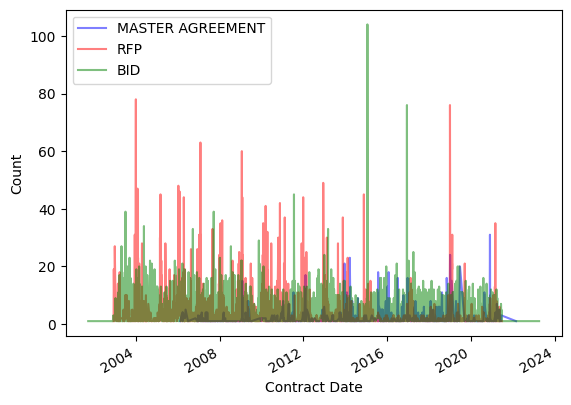

In [11]:
cols = ['b', 'r', 'g']
for i, typ in enumerate(['MASTER AGREEMENT', 'RFP', 'BID']):
    t = contracts[(pd.isna(contracts['Contract PDF'])==False)&(contracts['Procurement Type']==typ)]['Approval Date']
    df = pd.DataFrame({'date':pd.to_datetime(t)}) 
    s = df['date'].value_counts().sort_index()
    s.plot(color=cols[i], label=typ, alpha=0.5)

plt.legend()
plt.xlabel('Contract Date')
plt.ylabel('Count');

It appears as though the documents are largely distributed evenly throughout our timeframe, though it looks as though there are no Master Agreements available prior to about 2006. RFPs also seem to be much more "spiky" at particular points in time compared to Bids and Master Agreements, despite the total volume of Bids being higher than that of RFPs. 

### Exercise 1.1

Explore the main 3-5 categories of master agreements over time to confirm they have a similar distribution over the years.

<br/><br/><br/>

## Download Selected Sample

Now, we need to create a quick RPA tool so that we don't have to manually go to each URL and download the documents. Due to the nature of the website, we'll leverage Selenium. By configuring Selenium, we can automatically download the documents, given the URL link in the metadata file:

In [12]:
def download_pdf(lnk: str, download_folder: str):
    '''
    Behavior: Selenium is used (on Chrome web browser) to automatically download PDF files into the indicated folder.
    
    Parameters:
    - lnk (str): full URL from contract metadata to an individual PDF
    - download_folder (str): the local location folder path where the downloaded PDF file will be saved

    Returns: None
    '''
    options = webdriver.ChromeOptions()
    profile = {"plugins.plugins_list": [{"enabled": False,
                                         "name": "Chrome PDF Viewer"}],
               "download.default_directory": download_folder,
               "download.prompt_for_download": False,
               "plugins.always_open_pdf_externally": True}
    
    options.add_experimental_option("prefs", profile)            
    driver = webdriver.Chrome(options)
    driver.get(lnk)

    print("Downloading file from link: {}".format(lnk))
    time.sleep(2)
    WebDriverWait(driver, 10).until(EC.frame_to_be_available_and_switch_to_it((By.XPATH,"//iframe[@id='pdfFrame']")))
    time.sleep(2)
    WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.ID, "open-button"))).click()    
    time.sleep(20)
    
    filename = lnk.split("/")[-1].split('=')[-1]+'.pdf'
    os.rename(os.path.join(download_folder, "DPSWebDocumentViewer.pdf"), os.path.join(download_folder, filename))
    print("File: {}".format(filename))    
    print("Location: {}".format(os.path.join(download_folder, filename)))
    print("Status: Download Complete.")
    driver.close()
    return

<br/>

### Exercise 1.2:

Now that we have a quick script, test and confirm that it works for a single URL:

In [13]:
## Example usage
lnk = 'http://ecm.cityofchicago.org/eSMARTContracts/service/DPSWebDocumentViewer?sid=EDGE&id=000037ZS'
download_folder = os.path.join(HOME_DIRECTORY, 'data')
download_pdf(lnk, download_folder)

File: 000037ZS.pdf
Location: /Users/rachelwagner-kaiser/Desktop/000037ZS.pdf
Status: Download Complete.


<br/>

Feel free to check and confirm that this file ("000037ZS.pdf") was downloaded to the data folder successfully. Once confirmed, you can delete the file.

<br/>

Let's pick now take our sample and download - it will take some time to run over our selected sample. We'll save the downloaded PDFs to the "data_raw" folder in our repo. Alternatively, you can populate the "data_raw" folder from the folder provided on Google Drive.

In [14]:
download_folder = os.path.join(HOME_DIRECTORY, "data", "data_raw")


files0 = contracts[(pd.isna(contracts['Contract PDF'])==False)&(contracts['Procurement Type']=='MASTER AGREEMENT')]['Contract PDF'].values
files1 = contracts[(pd.isna(contracts['Contract PDF'])==False)&(contracts['Procurement Type']=='BID')]['Contract PDF'].sample(500, random_state=123)
files2 = contracts[(pd.isna(contracts['Contract PDF'])==False)&(contracts['Procurement Type']=='RFP')]['Contract PDF'].sample(300, random_state=234)
files3 = contracts[(pd.isna(contracts['Contract PDF'])==False)&(contracts['Procurement Type']=='RFQ')]['Contract PDF'].sample(200, random_state=345)
files = np.concatenate((files0, files1, files2, files3))

for i,f in enumerate(files):
    print(i)
    try:
        download_pdf(f, download_folder)
    except OSError as err:
        print("OS error:", err)
    except ValueError as err:
        print("URL or folder is invalid:", err)
    except Exception as err:
        print(f"Unexpected {err=}, {type(err)=}")
        raise

<br/>

### Exercise 1.3:

Check and confirm how many documents were successfully downloaded.

<br/><br/>

Now that we've pulled down our sample, we can really get started! Feel free to combine your downloaded sample with the data from the Google Drive.

<br/><br/><br/><br/>